<a href="https://colab.research.google.com/github/Irfanabdel/Prediction_Cryptocurrency_LSTM/blob/main/02_04_Crypto_LSTM_1H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------------
# @title Install Library
# -------------------------------
!pip install pandas_ta ccxt

In [2]:
#@title Import Library dan Lingkungan Pengembangan
# -------------------------------
# Library Machine Learning
# -------------------------------

import os # Modul untuk berinteraksi dengan sistem operasi
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# -------------------------------
# Library Pengambilan Data Crypto
# -------------------------------
import ccxt # Mengambil data historis cryptocurrency

# -------------------------------
# Library Indikator Teknikal
# -------------------------------
import pandas_ta as ta  # Perhitungan RSI, EMA, MACD

# -------------------------------
# Library Manipulasi Data
# -------------------------------
import pandas as pd # Pengolahan data tabular (DataFrame)
import numpy as np  # Operasi numerik dan array
import datetime     # Pengolahan tanggal dan waktu
import time         # Mengukur waktu eksekusi
import gc           # Manajemen memori

# -------------------------------
# Library Visualisasi
# -------------------------------
import matplotlib.pyplot as plt # Visualisasi grafik hasil prediksi
%matplotlib inline

# -------------------------------
# Library Preprocessing & Evaluasi
# -------------------------------
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error)

# **DATA UNDERSTANDING**

In [3]:
# ==========================================================
# @title Pengambilan Data Multi-Coin Multi-Timeframe
# Sumber: KuCoin (ccxt)
# Periode: 2020 - Sekarang
# Timeframe: 1h, 4h, 1d
# ==========================================================

csv_filename = '/content/drive/MyDrive/Colab Notebooks/Prediction_Crypto_LSTM/Dataset/dataset_multi_coin&timeframe_2020_Sekarang.csv'

try:
    df_loaded = pd.read_csv(csv_filename, index_col='Date', parse_dates=True)
    data = df_loaded.copy() # Simpan df_loaded ke variabel 'data' untuk proses selanjutnya
    print(f"Data berhasil dimuat dari '{csv_filename}'.")
    print("Lima baris pertama data:")
    display(data.head()) # Tampilkan 'data' bukan df_loaded
    print("Informasi data:")
    data.info() # Tampilkan info 'data' bukan df_loaded
except FileNotFoundError:
    print(f"Error: File '{csv_filename}' tidak ditemukan. Pastikan path file sudah benar.")
except Exception as e:
    print(f"Terjadi kesalahan saat memuat file: {e}")

Data berhasil dimuat dari '/content/drive/MyDrive/Colab Notebooks/Prediction_Crypto_LSTM/Dataset/dataset_multi_coin&timeframe_2020_Sekarang.csv'.
Lima baris pertama data:


,BTC_1h_Open,BTC_1h_High,BTC_1h_Low,BTC_1h_Close,BTC_1h_Volume,ETH_1h_Open,ETH_1h_High,ETH_1h_Low,ETH_1h_Close,ETH_1h_Volume,...,ALGO_4h_Open,ALGO_4h_High,ALGO_4h_Low,ALGO_4h_Close,ALGO_4h_Volume,ALGO_1d_Open,ALGO_1d_High,ALGO_1d_Low,ALGO_1d_Close,ALGO_1d_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7196.2,7196.2,7176.1,7180.4,11.351644,129.22,129.22,128.77,128.90,269.218945,...,0.2166,0.2188,0.2166,0.2188,6758.7350,0.2166,0.2358,0.2152,0.2198,80299.593942
2020-01-01 01:00:00,7180.5,7225.1,7179.9,7213.7,19.023154,128.90,130.60,128.88,130.59,482.740070,...,0.2166,0.2188,0.2166,0.2188,6758.7350,0.2166,0.2358,0.2152,0.2198,80299.593942
2020-01-01 02:00:00,7213.8,7242.6,7213.5,7241.6,17.281015,130.58,130.96,130.41,130.87,354.911942,...,0.2166,0.2188,0.2166,0.2188,6758.7350,0.2166,0.2358,0.2152,0.2198,80299.593942
2020-01-01 03:00:00,7241.6,7243.2,7221.6,7225.4,15.088046,130.87,130.93,129.97,130.16,735.020696,...,0.2166,0.2188,0.2166,0.2188,6758.7350,0.2166,0.2358,0.2152,0.2198,80299.593942
2020-01-01 04:00:00,7225.4,7229.3,7218.6,7220.9,8.341240,130.17,130.66,130.17,130.22,259.297509,...,0.2190,0.2200,0.2154,0.2160,11011.6693,0.2166,0.2358,0.2152,0.2198,80299.593942


Informasi data:
<class 'pandas.DataFrame'>
DatetimeIndex: 54016 entries, 2020-01-01 00:00:00 to 2026-02-28 15:00:00
Data columns (total 60 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BTC_1h_Open     54016 non-null  float64
 1   BTC_1h_High     54016 non-null  float64
 2   BTC_1h_Low      54016 non-null  float64
 3   BTC_1h_Close    54016 non-null  float64
 4   BTC_1h_Volume   54016 non-null  float64
 5   ETH_1h_Open     54016 non-null  float64
 6   ETH_1h_High     54016 non-null  float64
 7   ETH_1h_Low      54016 non-null  float64
 8   ETH_1h_Close    54016 non-null  float64
 9   ETH_1h_Volume   54016 non-null  float64
 10  ADA_1h_Open     54016 non-null  float64
 11  ADA_1h_High     54016 non-null  float64
 12  ADA_1h_Low      54016 non-null  float64
 13  ADA_1h_Close    54016 non-null  float64
 14  ADA_1h_Volume   54016 non-null  float64
 15  ALGO_1h_Open    54016 non-null  float64
 16  ALGO_1h_High    54016 non-null  floa

# **DATA PREPARATION**

In [4]:
# ==========================================================
# @title Pembersihan Data
# ==========================================================
print("Jumlah missing value sebelum drop:", data.isnull().sum().sum())

data = data.dropna()

print("Jumlah missing value setelah drop:", data.isnull().sum().sum())
print("Shape setelah cleaning:", data.shape)

Jumlah missing value sebelum drop: 0
Jumlah missing value setelah drop: 0
Shape setelah cleaning: (54016, 60)


In [5]:
# ==========================================================
# @title Feature Engineering (RSI, EMA, MACD)
# ==========================================================

print("Melakukan Feature Engineering (RSI, EMA, MACD)...")

# Indikator dihitung pada DataFrame 'data' yang sudah bersih (setelah dropna)
# dan belum diskalakan. Ini adalah urutan yang direkomendasikan.

coins = ['BTC', 'ETH', 'ADA', 'ALGO']
timeframes = ['1h', '4h', '1d']

for coin in coins:
    for tf in timeframes:
        print(f"  Menghitung indikator untuk {coin} {tf}...")
        prefix = f"{coin}_{tf}"
        close_col_name = f"{prefix}_Close"

        # Pastikan kolom Close ada dan numerik sebelum menghitung indikator
        # Operasikan langsung pada DataFrame 'data' yang sudah bersih.
        if close_col_name in data.columns and pd.api.types.is_numeric_dtype(data[close_col_name]):
            # Hitung RSI (Relative Strength Index)
            # Panjang default untuk RSI adalah 14
            data[f"{prefix}_RSI"] = ta.rsi(data[close_col_name], length=14)

            # Hitung EMA (Exponential Moving Average)
            # Menggunakan panjang umum seperti 20 untuk EMA
            data[f"{prefix}_EMA"] = ta.ema(data[close_col_name], length=20)

            # Hitung MACD (Moving Average Convergence Divergence)
            # Default cepat=12, lambat=26, sinyal=9
            macd_result = ta.macd(data[close_col_name], fast=12, slow=26, signal=9)

            if macd_result is not None and not macd_result.empty:
                # pandas_ta mengembalikan DataFrame dengan beberapa kolom terkait MACD
                # Tambahkan Garis MACD, Garis Sinyal MACD, dan Histogram MACD
                # Penugasan langsung ke 'data' akan bekerja karena indeks sejajar
                data[f"{prefix}_MACD_line"] = macd_result[f"MACD_{12}_{26}_{9}"]
                data[f"MACD_hist_{prefix}"] = macd_result[f"MACDh_{12}_{26}_{9}"]
                data[f"MACD_signal_{prefix}"] = macd_result[f"MACDs_{12}_{26}_{9}"]
            else:
                print(f"  Peringatan: Gagal menghitung MACD untuk {prefix}. Kolom mungkin tidak ada atau data tidak cukup.")
        else:
            print(f"  Peringatan: Kolom '{close_col_name}' tidak ditemukan atau bukan numerik. Melewatkan indikator untuk {coin} {tf}.")

# --- PENTING: Hapus baris dengan NaN yang muncul akibat perhitungan indikator ---
original_shape = data.shape
data = data.dropna()
print(f"Setelah feature engineering, {original_shape[0] - data.shape[0]} baris dengan NaN dihapus.")
# ---------------------------------------------------------------------------------

print("\nFeature Engineering (RSI, EMA, MACD) selesai.")
print("Shape data setelah feature engineering:", data.shape)
print("Contoh data terakhir setelah feature engineering (termasuk indikator baru):")
print(data.tail())

print("\nData kini telah diperbarui dengan fitur-fitur baru (RSI, EMA, MACD) dan dalam kondisi belum diskalakan.")

Melakukan Feature Engineering (RSI, EMA, MACD)...
  Menghitung indikator untuk BTC 1h...
  Menghitung indikator untuk BTC 4h...
  Menghitung indikator untuk BTC 1d...
  Menghitung indikator untuk ETH 1h...
  Menghitung indikator untuk ETH 4h...
  Menghitung indikator untuk ETH 1d...
  Menghitung indikator untuk ADA 1h...
  Menghitung indikator untuk ADA 4h...
  Menghitung indikator untuk ADA 1d...
  Menghitung indikator untuk ALGO 1h...
  Menghitung indikator untuk ALGO 4h...
  Menghitung indikator untuk ALGO 1d...
Setelah feature engineering, 33 baris dengan NaN dihapus.

Feature Engineering (RSI, EMA, MACD) selesai.
Shape data setelah feature engineering: (53983, 120)
Contoh data terakhir setelah feature engineering (termasuk indikator baru):
                     BTC_1h_Open  BTC_1h_High  BTC_1h_Low  BTC_1h_Close  \
Date                                                                      
2026-02-28 11:00:00      64006.4      64305.0     63796.1       63844.2   
2026-02-28 12:00:00 

In [6]:
# ==========================================================
# @title Normalisasi Data
# ==========================================================

# Memilih hanya kolom numerik untuk scaling
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

# Inisialisasi MinMaxScaler
# Menggunakan scaler baru agar tidak bentrok dengan scaler yang digunakan untuk model LSTM
scaler_data_frame = MinMaxScaler(feature_range=(0, 1))

# Terapkan scaling pada kolom numerik di DataFrame 'data'
data[numerical_cols] = scaler_data_frame.fit_transform(data[numerical_cols])

print("Data numerik di DataFrame 'data' telah berhasil dinormalisasi.")
print("Contoh data setelah normalisasi (5 baris terakhir):")
print(data[numerical_cols].tail())

Data numerik di DataFrame 'data' telah berhasil dinormalisasi.
Contoh data setelah normalisasi (5 baris terakhir):
                     BTC_1h_Open  BTC_1h_High  BTC_1h_Low  BTC_1h_Close  \
Date                                                                      
2026-02-28 11:00:00     0.491299     0.491013    0.494021      0.489980   
2026-02-28 12:00:00     0.489989     0.489154    0.494287      0.491425   
2026-02-28 13:00:00     0.491388     0.498439    0.494939      0.500338   
2026-02-28 14:00:00     0.500327     0.499684    0.497905      0.494746   
2026-02-28 15:00:00     0.494836     0.496860    0.497396      0.497887   

                     BTC_1h_Volume  ETH_1h_Open  ETH_1h_High  ETH_1h_Low  \
Date                                                                       
2026-02-28 11:00:00       0.013005     0.365455     0.365730    0.369079   
2026-02-28 12:00:00       0.008379     0.365095     0.364339    0.369231   
2026-02-28 13:00:00       0.019856     0.366201     0.3

In [7]:
# ==========================================================
# @title Mengatur Hyperparameter untuk Model LSTM Multi-Coin Multi-Timeframe
# ==========================================================

# Hyperparameter disesuaikan untuk model LSTM yang lebih powerful
neurons = 128                 # Jumlah unit neuron di setiap layer LSTM (dinaikkan untuk kompleksitas lebih)
activation_function = 'tanh'  # Fungsi aktivasi untuk layer LSTM
loss = 'mse'                  # Fungsi kerugian (loss function) untuk regresi
optimizer = 'adam'            # Optimizer untuk melatih model
dropout = 0.2                 # Tingkat Dropout untuk regulasi (dinaikkan untuk model lebih besar)
batch_size = 32               # Ukuran batch untuk pelatihan model
epochs = 50                   # Jumlah epoch pelatihan (dinaikkan untuk pembelajaran lebih lanjut)
window_len = 24               # Panjang jendela waktu untuk input LSTM (misal: 24 jam/periode)
training_size = 0.7           # Proporsi data untuk training (misal: 70%)
validation_size = 0.15        # Proporsi data untuk validasi (misal: 15%)
test_size = 0.15              # Proporsi data untuk pengujian (misal: 15%)

In [8]:
# ==========================================================
# @title Pembuatan Time Series Windowing untuk LSTM
# ==========================================================

print("Membuat windowing time series data...")

# Pilih fitur-fitur yang akan digunakan sebagai input untuk LSTM
# Kita akan menggunakan semua kolom numerik yang ada di DataFrame 'data' sebagai fitur input
# Kolom target (y) akan menjadi harga 'Close' BTC pada timeframe 1 jam

# Memastikan kolom Date di-drop sebelum mengambil semua kolom numerik untuk fitur
# karena kita tidak ingin Date menjadi bagian dari fitur numerik untuk model
feature_cols = data.select_dtypes(include=np.number).columns.tolist()

# Pisahkan data menjadi training, validation, dan testing set
total_len = len(data)
train_size = int(total_len * training_size)
val_size = int(total_len * validation_size)
test_size_actual = total_len - train_size - val_size

train_data = data[feature_cols].iloc[:train_size]
validation_data = data[feature_cols].iloc[train_size:train_size + val_size]
test_data = data[feature_cols].iloc[train_size + val_size:]

print(f"Ukuran data training: {len(train_data)}")
print(f"Ukuran data validation: {len(validation_data)}")
print(f"Ukuran data testing: {len(test_data)}")

# Fungsi untuk membuat sequence input (X) dan output (y) untuk LSTM
# y akan menjadi harga Close BTC_1h berikutnya
def create_sequences(dataset, window_len):
    X, y = [], []
    # Menemukan indeks kolom target 'BTC_1h_Close'
    try:
        btc_close_idx = dataset.columns.get_loc('BTC_1h_Close')
    except KeyError:
        print("Kolom 'BTC_1h_Close' tidak ditemukan. Harap pastikan nama kolom sudah benar.")
        return np.array([]), np.array([])

    for i in range(window_len, len(dataset)):
        X.append(dataset.iloc[i-window_len:i].values) # window_len periode sebelumnya sebagai input
        y.append(dataset.iloc[i, btc_close_idx])     # Harga Close BTC_1h pada periode saat ini sebagai target
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, window_len)
X_val, y_val = create_sequences(validation_data, window_len)
X_test, y_test = create_sequences(test_data, window_len)

# Cek shape data sebelum reshape (untuk debugging jika diperlukan)
print("Shape X_train sebelum reshape:", X_train.shape)
print("Shape X_val sebelum reshape:", X_val.shape)
print("Shape X_test sebelum reshape:", X_test.shape)

# Reshape X untuk input LSTM: (samples, timesteps, features)
# Timesteps adalah window_len
# Features adalah jumlah kolom fitur yang dipilih
if X_train.size > 0:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
else:
    print("X_train kosong, periksa data.")

if X_val.size > 0:
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
else:
    print("X_val kosong, periksa data.")

if X_test.size > 0:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
else:
    print("X_test kosong, periksa data.")

print("Shape X_train (LSTM input):")
print(X_train.shape)
print("Shape y_train:")
print(y_train.shape)
print("Shape X_val (LSTM input):")
print(X_val.shape)
print("Shape y_val:")
print(y_val.shape)
print("Shape X_test (LSTM input):")
print(X_test.shape)
print("Shape y_test:")
print(y_test.shape)

print("Windowing time series data selesai.")

Membuat windowing time series data...
Ukuran data training: 37788
Ukuran data validation: 8097
Ukuran data testing: 8098
Shape X_train sebelum reshape: (37764, 24, 120)
Shape X_val sebelum reshape: (8073, 24, 120)
Shape X_test sebelum reshape: (8074, 24, 120)
Shape X_train (LSTM input):
(37764, 24, 120)
Shape y_train:
(37764,)
Shape X_val (LSTM input):
(8073, 24, 120)
Shape y_val:
(8073,)
Shape X_test (LSTM input):
(8074, 24, 120)
Shape y_test:
(8074,)
Windowing time series data selesai.


# **Modeling**

In [9]:
# ==========================================================
# @title Membangun dan Compile Model LSTM (Optimized for 4GB VRAM)
# ==========================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Pastikan 'neurons' sudah diubah (disarankan 128 atau 256)
# Jika tetap ingin mencoba angka tinggi, jangan melebihi 256 untuk 3 layer di GTX 1650

model = Sequential()

# Input Layer & Layer LSTM 1
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=neurons, return_sequences=True, activation=activation_function))
model.add(Dropout(dropout))

# Layer LSTM 2
model.add(LSTM(units=neurons, return_sequences=True, activation=activation_function))
model.add(Dropout(dropout))

# Layer LSTM 3 (Terakhir - return_sequences=False)
model.add(LSTM(units=neurons, return_sequences=False, activation=activation_function))
model.add(Dropout(dropout))

# Output Layer
model.add(Dense(units=1))

# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

# Tampilkan ringkasan untuk melihat total parameter
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │       127,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,785 (1.49 MB)

 Trainable params: 390,785 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Memulai pelatihan model LSTM...
Epoch 1/50
1180/1181 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0045 - mae: 0.0326
Epoch 1: val_loss improved from inf to 0.00076, saving model to /content/drive/MyDrive/Colab Notebooks/Prediction_Crypto_LSTM/04_1HBTC/best_model.keras
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 177s 146ms/step - loss: 0.0045 - mae: 0.0326 - val_loss: 7.5983e-04 - val_mae: 0.0254
Epoch 2/50
1180/1181 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 2.9468e-04 - mae: 0.0125
Epoch 2: val_loss did not improve from 0.00076
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 172s 145ms/step - loss: 2.9462e-04 - mae: 0.0125 - val_loss: 8.7514e-04 - val_mae: 0.0238
Epoch 3/50
1180/1181 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.9397e-04 - mae: 0.0101
Epoch 3: val_loss did not improve from 0.00076
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 167s 141ms/step - loss: 1.9396e-04 - mae: 0.0101 - val_loss: 0.0046 - val_mae: 0.0583
Epoch 4/50
1180/1181 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 1.7308e-04 - mae: 0.0095
Epoch 4: val_lo

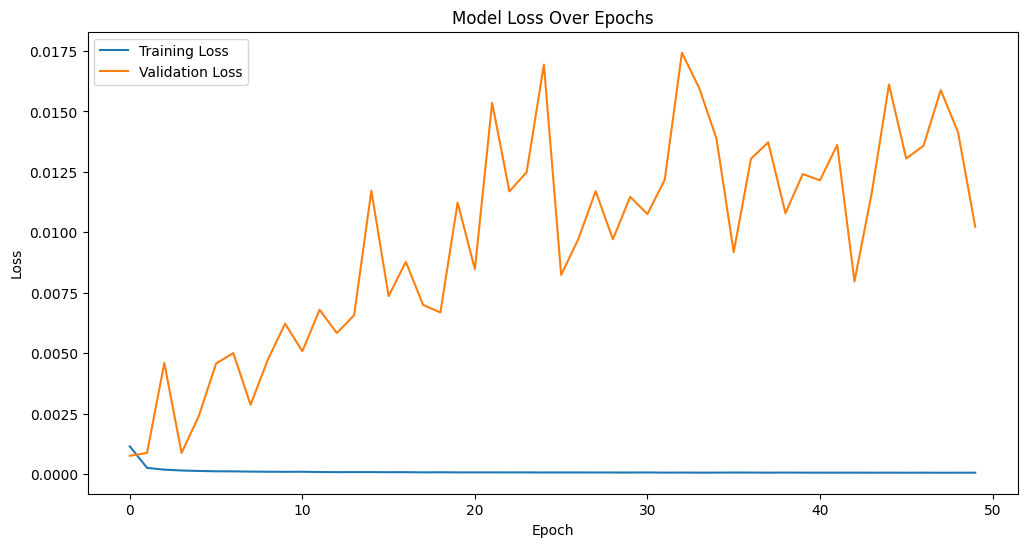

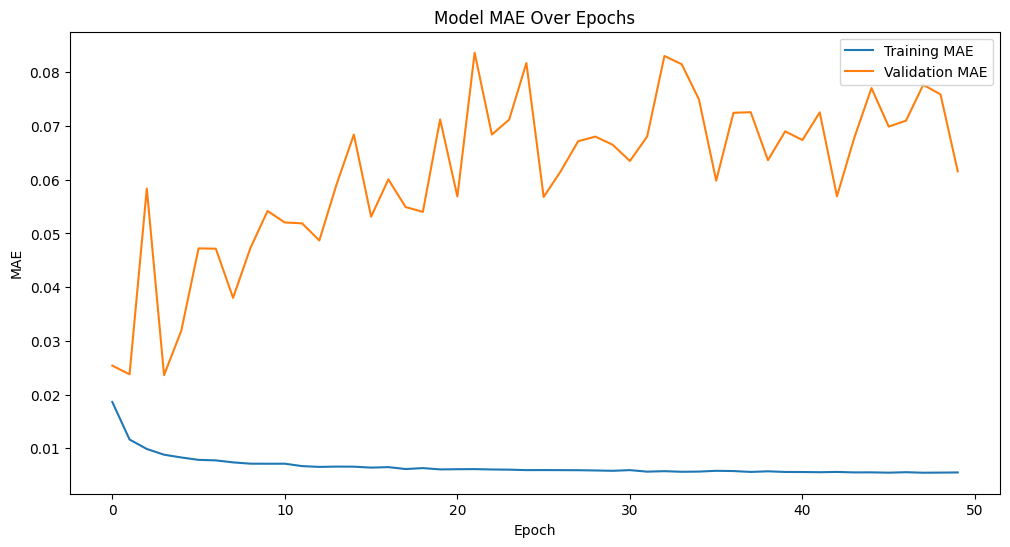

In [10]:
# ==========================================================
# @title Pelatihan Model LSTM
# ==========================================================

print("Memulai pelatihan model LSTM...")

# Impor ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
import os # Import os module for directory creation

# Definisikan path untuk menyimpan model terbaik
model_dir = '/content/drive/MyDrive/Colab Notebooks/Prediction_Crypto_LSTM/04_1HBTC/'
# Buat direktori jika belum ada
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Direktori '{model_dir}' dibuat.")

filepath = os.path.join(model_dir, 'best_model.keras')
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks_list = [checkpoint]

# Memulai pelatihan model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val), # Menggunakan X_val dan y_val sebagai data validasi
    callbacks=callbacks_list, # Tambahkan callbacks di sini
    verbose=1
)

print("Pelatihan model selesai.")

# Plot history pelatihan
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# **Model Evaluation**

In [11]:
# ==========================================================
# @title Evaluasi Model
# ==========================================================

print("Melakukan prediksi pada data pengujian...")

# Memuat model terbaik yang telah disimpan
from tensorflow.keras.models import load_model

model_dir = '/content/drive/MyDrive/Colab Notebooks/Prediction_Crypto_LSTM/04_1HBTC/'
filepath = os.path.join(model_dir, 'best_model.keras')
model = load_model(filepath)

# Melakukan prediksi menggunakan data uji
predictions = model.predict(X_test)

# Karena target (y_test) adalah 'BTC_4h_Close' yang telah dinormalisasi,
# maka hasil prediksi juga berada pada rentang 0–1.
# Oleh karena itu, perlu dilakukan proses denormalisasi (inverse scaling)
# agar hasil kembali ke skala harga asli.

# Untuk melakukan denormalisasi, digunakan scaler yang sama
# saat proses normalisasi seluruh DataFrame.
# Karena normalisasi dilakukan terhadap seluruh fitur sekaligus,
# maka inverse_transform memerlukan array dengan jumlah fitur yang sama.

# Mengambil kembali daftar fitur numerik
feature_cols = data.select_dtypes(include=np.number).columns.tolist()

# Menentukan indeks kolom target (BTC_1h_Close)
btc_close_idx = feature_cols.index('BTC_1h_Close')

# Membuat array dummy dengan jumlah fitur yang sama
dummy_array_for_inverse = np.zeros((len(y_test), len(feature_cols)))

# Memasukkan nilai y_test yang sudah dinormalisasi ke kolom target
dummy_array_for_inverse[:, btc_close_idx] = y_test

# Melakukan denormalisasi
y_test_denormalisasi = scaler_data_frame.inverse_transform(dummy_array_for_inverse)[:, btc_close_idx]

# Proses yang sama untuk hasil prediksi
dummy_array_for_inverse_pred = np.zeros((len(predictions), len(feature_cols)))
dummy_array_for_inverse_pred[:, btc_close_idx] = predictions.flatten()

predictions_denormalisasi = scaler_data_frame.inverse_transform(dummy_array_for_inverse_pred)[:, btc_close_idx]

print("Menghitung metrik evaluasi model...")

# Menghitung metrik evaluasi
mae = mean_absolute_error(y_test_denormalisasi, predictions_denormalisasi)
rmse = root_mean_squared_error(y_test_denormalisasi, predictions_denormalisasi)
mape = mean_absolute_percentage_error(y_test_denormalisasi, predictions_denormalisasi) * 100  # dalam persen

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print("Proses evaluasi model selesai.")

Melakukan prediksi pada data pengujian...
253/253 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step
Menghitung metrik evaluasi model...
Mean Absolute Error (MAE): 5947.6677
Root Mean Squared Error (RMSE): 7447.9815
Mean Absolute Percentage Error (MAPE): 5.55%
Proses evaluasi model selesai.


Visualisasi Hasil Prediksi...


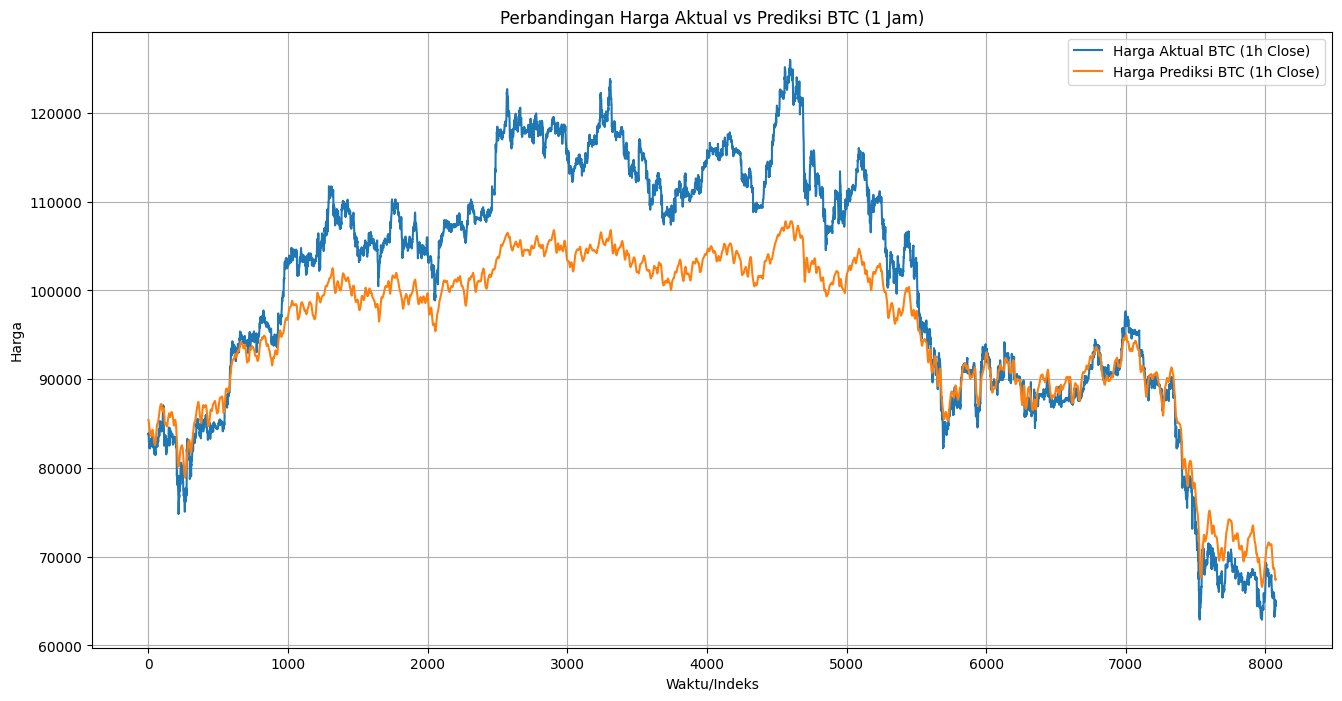

Plot untuk volatilitas BTC dan harga Penutupan 1-hari BTC/ETH telah dihasilkan.


In [14]:
# ==========================================================
# @title Visualisasi Hasil Prediksi
# ==========================================================

print("Visualisasi Hasil Prediksi...")

# Visualisasi Hasil Prediksi
plt.figure(figsize=(16, 8))
plt.plot(y_test_denormalisasi, label='Harga Aktual BTC (1h Close)')
plt.plot(predictions_denormalisasi, label='Harga Prediksi BTC (1h Close)')
plt.title('Perbandingan Harga Aktual vs Prediksi BTC (1 Jam)')
plt.xlabel('Waktu/Indeks')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

print("Plot untuk volatilitas BTC dan harga Penutupan 1-hari BTC/ETH telah dihasilkan.")

# **Backtesting Strategy**


In [15]:
# ==========================================================
# @title Aturan Trading Berbasis Prediksi LSTM
# ==========================================================

print("Mendefinisikan aturan trading berdasarkan hasil prediksi model LSTM...")

# 1. Mengambil tanggal yang sesuai dengan data pengujian
# DataFrame 'data' asli menggunakan kolom 'Date' sebagai indeks.
# Data pengujian dimulai dari train_size + window_len
# karena pembentukan sequence dimulai setelah window_len.
# Correction: tanggal_uji should correspond to the actual indices of y_test_denormalisasi
# which are the dates from test_data after the window_len offset.
tanggal_uji = test_data.index[window_len:]

# 2. Membuat DataFrame baru untuk strategi LSTM
lstm_strategy_data = pd.DataFrame({
    'Harga_Aktual': y_test_denormalisasi,
    'Harga_Prediksi': predictions_denormalisasi.flatten()  # Pastikan berbentuk 1 dimensi
}, index=tanggal_uji)

# 3. Menentukan ambang batas pembelian (buy threshold)
buy_threshold = 0.005  # 0,5% kenaikan harga prediksi untuk menghasilkan sinyal beli

# 4. Membuat kolom 'Sinyal_Beli'
# Sinyal beli muncul jika harga prediksi lebih tinggi secara signifikan
# dibandingkan harga aktual saat ini
lstm_strategy_data['Sinyal_Beli'] = (
    lstm_strategy_data['Harga_Prediksi'] >
    lstm_strategy_data['Harga_Aktual'] * (1 + buy_threshold)
).astype(int)

# Membuat kolom 'Sinyal_Jual'
# Sinyal jual muncul jika harga prediksi lebih rendah atau sama dengan harga aktual
lstm_strategy_data['Sinyal_Jual'] = (
    lstm_strategy_data['Harga_Prediksi'] <=
    lstm_strategy_data['Harga_Aktual']
).astype(int)

# 5. Inisialisasi kolom tambahan untuk simulasi trading
lstm_strategy_data['Posisi'] = 0        # 0: tidak ada posisi, 1: posisi long
lstm_strategy_data['Harga_Masuk'] = np.nan
lstm_strategy_data['Transaksi_Beli'] = 0
lstm_strategy_data['Transaksi_Jual'] = 0

print("Aturan trading berbasis prediksi LSTM berhasil didefinisikan.")
print("Contoh data strategi (5 baris pertama):")
print(lstm_strategy_data.head())

Mendefinisikan aturan trading berdasarkan hasil prediksi model LSTM...
Aturan trading berbasis prediksi LSTM berhasil didefinisikan.
Contoh data strategi (5 baris pertama):
                     Harga_Aktual  Harga_Prediksi  Sinyal_Beli  Sinyal_Jual  \
Date                                                                          
2025-03-29 06:00:00       83791.5    85406.079040            1            0   
2025-03-29 07:00:00       83727.2    85367.645594            1            0   
2025-03-29 08:00:00       83928.6    85302.691544            1            0   
2025-03-29 09:00:00       83545.3    85201.919061            1            0   
2025-03-29 10:00:00       82914.1    85066.207082            1            0   

                     Posisi  Harga_Masuk  Transaksi_Beli  Transaksi_Jual  
Date                                                                      
2025-03-29 06:00:00       0          NaN               0               0  
2025-03-29 07:00:00       0          NaN        

In [16]:
# ==========================================================
# @title Simulasi Perdagangan dengan Sinyal Beli
# ==========================================================

print("\nMelakukan simulasi perdagangan dengan sinyal BELI berbasis prediksi LSTM...")

modal_awal = 100000  # Modal awal
kas_saat_ini = modal_awal
posisi = 0           # 0: tidak ada posisi, 1: posisi beli (long)
harga_masuk = 0      # Harga saat masuk posisi
jumlah_unit = 0      # Jumlah unit kripto yang dibeli
catatan_perdagangan = []  # Menyimpan detail setiap transaksi
data_ekuitas = [{'Date': lstm_strategy_data.index[0], 'Cash': modal_awal}]  # Untuk kurva ekuitas


# Fungsi untuk menghitung persentase keuntungan/kerugian
def hitung_profit_loss(harga_beli, harga_jual):
    return ((harga_jual - harga_beli) / harga_beli) * 100


for i in range(len(lstm_strategy_data)):
    tanggal_sekarang = lstm_strategy_data.index[i]
    harga_aktual = lstm_strategy_data['Harga_Aktual'].iloc[i]
    harga_prediksi = lstm_strategy_data['Harga_Prediksi'].iloc[i]
    sinyal_beli = lstm_strategy_data['Sinyal_Beli'].iloc[i]

    # Cek sinyal BELI
    if sinyal_beli == 1 and posisi == 0:
        # Masuk posisi (beli)
        harga_masuk = harga_aktual
        jumlah_unit = kas_saat_ini / harga_masuk  # Beli dengan seluruh modal
        posisi = 1
        lstm_strategy_data.loc[tanggal_sekarang, 'Posisi'] = 1
        lstm_strategy_data.loc[tanggal_sekarang, 'Harga_Masuk'] = harga_masuk
        lstm_strategy_data.loc[tanggal_sekarang, 'Transaksi_Beli'] = 1

    # Cek sinyal JUAL (jika sedang memiliki posisi)
    if posisi == 1:
        # Keluar jika prediksi tidak lagi bullish
        if harga_prediksi <= harga_aktual:
            harga_keluar = harga_aktual
            persen_profit_loss = hitung_profit_loss(harga_masuk, harga_keluar)
            kas_saat_ini = jumlah_unit * harga_keluar

            catatan_perdagangan.append({
                'Tanggal_Masuk': lstm_strategy_data.loc[
                    lstm_strategy_data['Harga_Masuk'] == harga_masuk
                ].index[0] if not lstm_strategy_data.loc[
                    lstm_strategy_data['Harga_Masuk'] == harga_masuk
                ].empty else tanggal_sekarang,
                'Harga_Masuk': harga_masuk,
                'Tanggal_Keluar': tanggal_sekarang,
                'Harga_Keluar': harga_keluar,
                'Persentase_Profit_Loss': persen_profit_loss,
                'Kas_Setelah_Transaksi': kas_saat_ini
            })

            lstm_strategy_data.loc[tanggal_sekarang, 'Posisi'] = 0
            lstm_strategy_data.loc[tanggal_sekarang, 'Transaksi_Jual'] = 1

            posisi = 0
            harga_masuk = 0
            jumlah_unit = 0

    # Memperbarui kurva ekuitas
    if posisi == 1:
        data_ekuitas.append({'Date': tanggal_sekarang, 'Cash': jumlah_unit * harga_aktual})
    else:
        data_ekuitas.append({'Date': tanggal_sekarang, 'Cash': kas_saat_ini})


# Jika masih ada posisi terbuka di akhir data, tutup paksa
if posisi == 1:
    harga_keluar = lstm_strategy_data['Harga_Aktual'].iloc[-1]
    persen_profit_loss = hitung_profit_loss(harga_masuk, harga_keluar)
    kas_saat_ini = jumlah_unit * harga_keluar

    tanggal_masuk_terakhir = lstm_strategy_data.loc[
        lstm_strategy_data['Harga_Masuk'] == harga_masuk
    ].index[0] if harga_masuk != 0 and not lstm_strategy_data.loc[
        lstm_strategy_data['Harga_Masuk'] == harga_masuk
    ].empty else lstm_strategy_data.index[-1]

    catatan_perdagangan.append({
        'Tanggal_Masuk': tanggal_masuk_terakhir,
        'Harga_Masuk': harga_masuk,
        'Tanggal_Keluar': lstm_strategy_data.index[-1],
        'Harga_Keluar': harga_keluar,
        'Persentase_Profit_Loss': persen_profit_loss,
        'Kas_Setelah_Transaksi': kas_saat_ini
    })

    lstm_strategy_data.loc[lstm_strategy_data.index[-1], 'Posisi'] = 0
    lstm_strategy_data.loc[lstm_strategy_data.index[-1], 'Transaksi_Jual'] = 1


# Mengubah catatan perdagangan dan kurva ekuitas menjadi DataFrame
df_catatan_perdagangan = pd.DataFrame(catatan_perdagangan)
kurva_ekuitas = pd.DataFrame(data_ekuitas).set_index('Date')
kurva_ekuitas.index = pd.to_datetime(kurva_ekuitas.index)

print("\nSimulasi perdagangan selesai.")
print(f"Modal akhir: {kas_saat_ini:.2f}")

if not df_catatan_perdagangan.empty:
    print("\nCatatan Perdagangan (5 transaksi terakhir):")
    print(df_catatan_perdagangan.tail())
else:
    print("\nTidak terdapat transaksi yang tercatat.")

print("\nKurva Ekuitas (5 baris terakhir):")
print(kurva_ekuitas.tail())


Melakukan simulasi perdagangan dengan sinyal BELI berbasis prediksi LSTM...

Simulasi perdagangan selesai.
Modal akhir: 108349.71

Catatan Perdagangan (5 transaksi terakhir):
         Tanggal_Masuk  Harga_Masuk      Tanggal_Keluar  Harga_Keluar  \
40 2026-01-23 19:00:00      89983.6 2026-01-24 20:00:00       89380.8   
41 2026-01-26 11:00:00      87853.3 2026-02-06 16:00:00       69962.8   
42 2026-02-06 18:00:00      69776.7 2026-02-06 19:00:00       70732.0   
43 2026-02-06 20:00:00      70021.5 2026-02-06 22:00:00       71354.6   
44 2026-02-06 23:00:00      70580.3 2026-02-28 15:00:00       64807.9   

    Persentase_Profit_Loss  Kas_Setelah_Transaksi  
40               -0.669900          143442.597840  
41              -20.364061          114231.859067  
42                1.369082          115795.786495  
43                1.903844          118000.357419  
44               -8.178486          108349.714631  

Kurva Ekuitas (5 baris terakhir):
                              Cash
Dat


Memvisualisasikan kinerja strategi BELI berbasis LSTM...


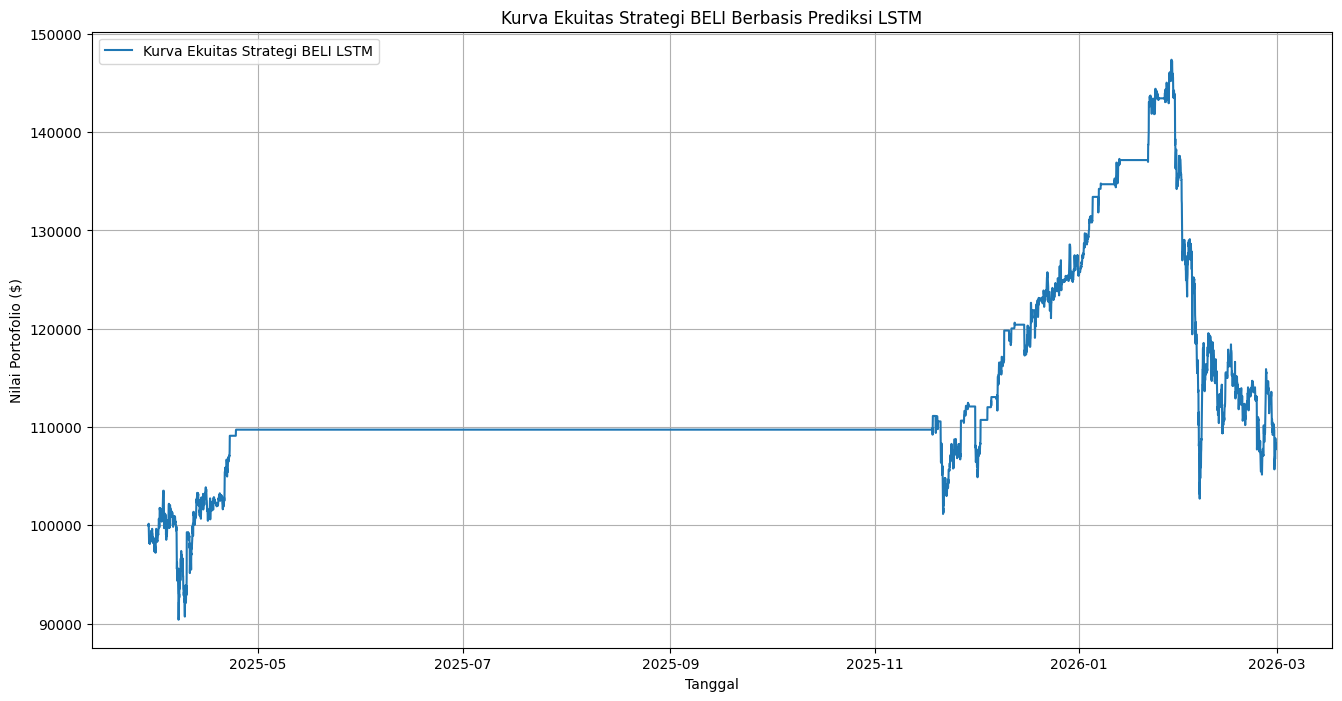

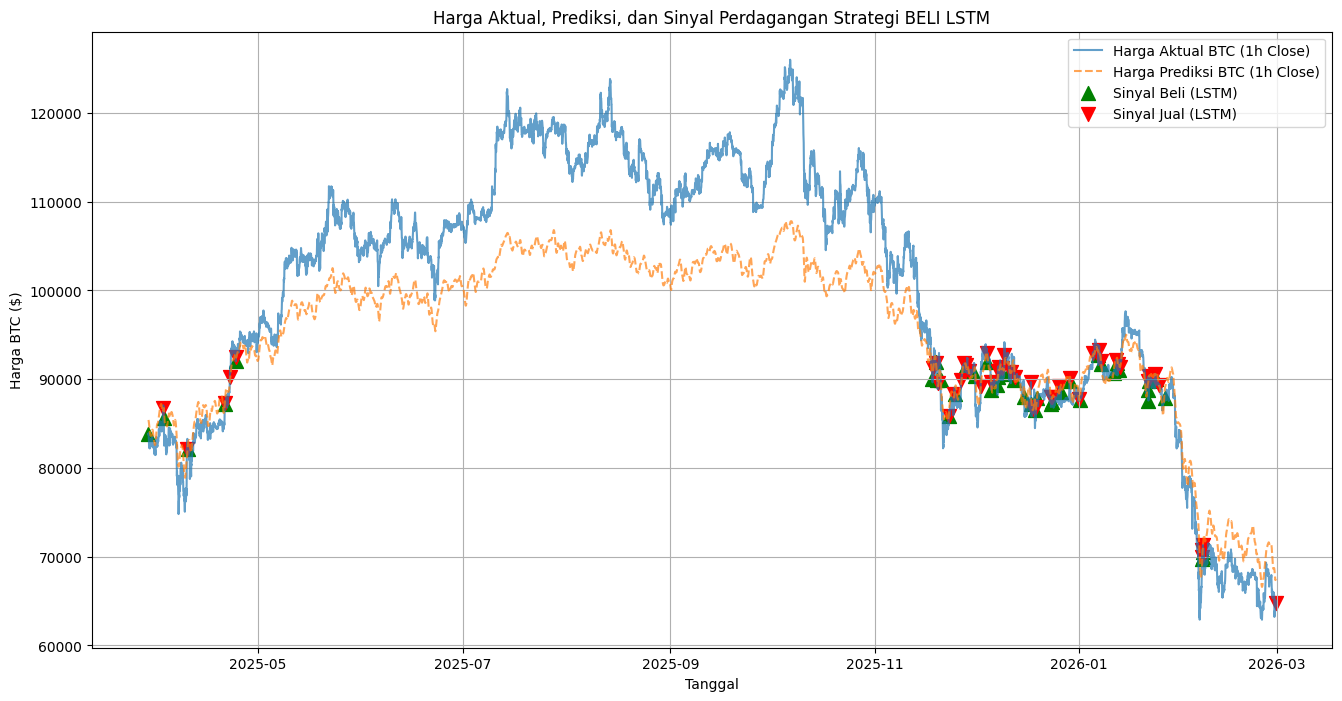


Visualisasi kinerja strategi BELI berbasis LSTM selesai.


In [17]:
# ==========================================================
# @title Visualisasi Kinerja Strategi Beli
# ==========================================================
print("\nMemvisualisasikan kinerja strategi BELI berbasis LSTM...")

# Plot kurva ekuitas
plt.figure(figsize=(16, 8))
plt.plot(kurva_ekuitas['Cash'], label='Kurva Ekuitas Strategi BELI LSTM')
plt.title('Kurva Ekuitas Strategi BELI Berbasis Prediksi LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Portofolio ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot harga aktual, harga prediksi, dan sinyal beli/jual
plt.figure(figsize=(16, 8))
plt.plot(lstm_strategy_data['Harga_Aktual'], label='Harga Aktual BTC (1h Close)', alpha=0.7)
plt.plot(lstm_strategy_data['Harga_Prediksi'], label='Harga Prediksi BTC (1h Close)', alpha=0.7, linestyle='--')

# Plot sinyal beli
buy_signals = lstm_strategy_data[lstm_strategy_data['Transaksi_Beli'] == 1]
plt.scatter(buy_signals.index, buy_signals['Harga_Aktual'], marker='^', color='green', s=100, label='Sinyal Beli (LSTM)')

# Plot sinyal jual (jika ada)
sell_signals = lstm_strategy_data[lstm_strategy_data['Transaksi_Jual'] == 1]
plt.scatter(sell_signals.index, sell_signals['Harga_Aktual'], marker='v', color='red', s=100, label='Sinyal Jual (LSTM)')


plt.title('Harga Aktual, Prediksi, dan Sinyal Perdagangan Strategi BELI LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Harga BTC ($)')
plt.legend()
plt.grid(True)
plt.show()

print("\nVisualisasi kinerja strategi BELI berbasis LSTM selesai.")

In [18]:
# ==========================================================
# @title Menghitung Metrik Backtesting
# ==========================================================
print("\nMenghitung metrik backtesting untuk strategi BELI berbasis LSTM...")

if not df_catatan_perdagangan.empty:
    # Total Return
    lstm_total_return = ((kas_saat_ini - modal_awal) / modal_awal) * 100
    print(f"Total Return: {lstm_total_return:.2f}%")

    # Win Rate
    lstm_profitable_trades = df_catatan_perdagangan[df_catatan_perdagangan['Persentase_Profit_Loss'] > 0]
    lstm_win_rate = (len(lstm_profitable_trades) / len(df_catatan_perdagangan)) * 100
    print(f"Win Rate: {lstm_win_rate:.2f}%")

    # Maximum Drawdown
    # Hitung return harian untuk kurva ekuitas
    lstm_daily_returns = kurva_ekuitas['Cash'].pct_change()
    lstm_roll_max = kurva_ekuitas['Cash'].expanding().max()
    lstm_drawdown = (kurva_ekuitas['Cash'] / lstm_roll_max) - 1.0
    lstm_max_drawdown = lstm_drawdown.min() * 100 # Dalam persentase
    abs_lstm_max_drawdown_val = lstm_max_drawdown # Pertahankan sebagai persentase negatif
    print(f"Maximum Drawdown: {abs_lstm_max_drawdown_val:.2f}%")


    # Sharpe Ratio
    # Asumsi risk_free_rate = 0 untuk kemudahan, atau bisa gunakan tingkat bunga bank sentral
    risk_free_rate = 0 # Bisa disesuaikan
    lstm_avg_daily_return = lstm_daily_returns.mean()
    lstm_std_daily_return = lstm_daily_returns.std()

    if lstm_std_daily_return != 0:
        # Annualisasi Sharpe Ratio. Faktor annualisasi tergantung timeframe data.
        # Untuk data 1 jam, ada 24/1 * 365 = 24 * 365 periode per tahun.
        annualization_factor = np.sqrt(24 * 365) # For 1-hour data
        lstm_sharpe_ratio = (lstm_avg_daily_return - (risk_free_rate / annualization_factor)) / lstm_std_daily_return * annualization_factor
        print(f"Sharpe Ratio: {lstm_sharpe_ratio:.2f}")
    else:
        lstm_sharpe_ratio = np.nan
        print("Sharpe Ratio: Tidak dapat dihitung (deviasi standar nol).")

else:
    print("Tidak ada transaksi yang dilakukan, metrik tidak dapat dihitung.")

print("\nPenghitungan metrik backtesting selesai.")


Menghitung metrik backtesting untuk strategi BELI berbasis LSTM...
Total Return: 8.35%
Win Rate: 73.33%
Maximum Drawdown: -30.30%
Sharpe Ratio: 0.45

Penghitungan metrik backtesting selesai.


In [24]:
# ==========================================================
# @title Mengonversi y_test_denormalisasi menjadi Pandas Series
# ==========================================================

print("Mengonversi y_test_denormalisasi menjadi Pandas Series...")

# Mengonversi y_test_denormalisasi ke Pandas Series dengan indeks yang sesuai
# Indeks tanggal uji diperoleh dari sel prediksi N-langkah ke depan.
# Kita perlu menghitung ulang atau memastikan variabel ini tersedia.
# Untuk menyederhanakan, kita akan mendapatkannya di sini berdasarkan panjang y_test_denormalisasi.

# Memastikan DataFrame 'data' tersedia dan memiliki indeks
if 'data' not in globals() or data.empty:
    raise ValueError("DataFrame 'data' tidak ditemukan atau kosong. Pastikan langkah pengumpulan data telah dijalankan.")

# Membuat ulang indeks tanggal uji dari DataFrame 'test_data'
# y_test sesuai dengan data dari indeks (window_len) dan seterusnya di indeks 'test_data'
actual_prices_series_index = test_data.index[window_len:]

# Pastikan panjang y_test_denormalisasi cocok dengan indeks yang baru dibuat
if len(y_test_denormalisasi) != len(actual_prices_series_index):
    raise ValueError("Panjang y_test_denormalisasi tidak sesuai dengan panjang indeks tanggal uji yang dihitung.")

Harga_Aktual_Series = pd.Series(y_test_denormalisasi, index=actual_prices_series_index)

print("Pandas Series 'Harga_aktual_Series' telah dibuat.")
print(Harga_Aktual_Series.head())

Mengonversi y_test_denormalisasi menjadi Pandas Series...
Pandas Series 'Harga_aktual_Series' telah dibuat.
Date
2025-03-29 06:00:00    83791.5
2025-03-29 07:00:00    83727.2
2025-03-29 08:00:00    83928.6
2025-03-29 09:00:00    83545.3
2025-03-29 10:00:00    82914.1
dtype: float64


In [25]:
# ==========================================================
# @title Arah Pergerakan Harga Aktual
# ==========================================================
print("Menghitung arah pergerakan harga aktual...")

# 1. Konversi y_test_denormalisasi menjadi Pandas Series dengan indeks yang sesuai
# Langkah ini sekarang ditangani oleh sel 4b39f1f2, memastikan Harga_Aktual_Series telah didefinisikan.
# Jika Harga_Aktual_Series belum didefinisikan, jalankan sel sebelumnya terlebih dahulu.
if 'Harga_Aktual_Series' not in globals():
    raise NameError("'Harga_Aktual_Series' belum didefinisikan. Harap jalankan sel sebelumnya.")

# 2. Hitung perubahan persentase harian
actual_percentage_change = Harga_Aktual_Series.pct_change()

# 3. Buat Series baru 'actual_directions'
# 1 untuk naik, -1 untuk turun, 0 untuk tidak berubah
actual_directions = np.sign(actual_percentage_change)

print("Arah pergerakan harga aktual telah dihitung.")
print(actual_directions.head())

Menghitung arah pergerakan harga aktual...
Arah pergerakan harga aktual telah dihitung.
Date
2025-03-29 06:00:00    NaN
2025-03-29 07:00:00   -1.0
2025-03-29 08:00:00    1.0
2025-03-29 09:00:00   -1.0
2025-03-29 10:00:00   -1.0
dtype: float64


In [26]:
# ==========================================================
# @title Arah Pergerakan Harga Prediksi
# ==========================================================
print("Menghitung arah pergerakan harga prediksi...")

# 1. Konversi predictions_denormalisasi menjadi Pandas Series dengan indeks yang sesuai
predicted_prices_series = pd.Series(predictions_denormalisasi.flatten(), index=lstm_strategy_data.index)

# 2. Hitung perubahan persentase harian untuk harga prediksi
predicted_percentage_change = predicted_prices_series.pct_change()

# 3. Buat Series baru 'predicted_directions'
# 1 untuk naik, -1 untuk turun, 0 untuk tidak berubah
predicted_directions = np.sign(predicted_percentage_change)

print("Arah pergerakan harga prediksi telah dihitung.")
print(predicted_directions.head())

Menghitung arah pergerakan harga prediksi...
Arah pergerakan harga prediksi telah dihitung.
Date
2025-03-29 06:00:00    NaN
2025-03-29 07:00:00   -1.0
2025-03-29 08:00:00   -1.0
2025-03-29 09:00:00   -1.0
2025-03-29 10:00:00   -1.0
dtype: float64


In [27]:
# ==========================================================
# @title Akurasi Arah Pergerakan Harga
# ==========================================================
print("Menghitung akurasi arah pergerakan harga...")

# Pastikan semua series yang diperlukan didefinisikan
if 'predicted_directions' not in globals():
    raise NameError("'predicted_directions' belum didefinisikan. Jalankan sel 'Menghitung arah pergerakan harga prediksi...' terlebih dahulu.")
if 'actual_directions' not in globals():
    raise NameError("'actual_directions' belum didefinisikan. Jalankan sel 'Menghitung arah pergerakan harga aktual...' terlebih dahulu.")

# Hapus baris pertama (NaN) karena pct_change() menghasilkan NaN untuk entri pertama
actual_directions_cleaned = actual_directions.dropna()
predicted_directions_cleaned = predicted_directions.dropna()

# Pastikan indeks selaras setelah dropna
common_index = actual_directions_cleaned.index.intersection(predicted_directions_cleaned.index)
actual_directions_aligned = actual_directions_cleaned.loc[common_index]
predicted_directions_aligned = predicted_directions_cleaned.loc[common_index]

# Bandingkan arah yang diprediksi dengan arah aktual
# Cocokkan jika arahnya sama (1==1 atau -1==-1)
matches = (actual_directions_aligned == predicted_directions_aligned)

# Hitung akurasi arah
if len(matches) > 0:
    directional_accuracy = (matches.sum() / len(matches)) * 100
    print(f"Akurasi Arah (Directional Accuracy): {directional_accuracy:.2f}%")
else:
    directional_accuracy = 0.0
    print("Tidak ada data yang cocok untuk menghitung akurasi arah.")

# Tambahkan ke DataFrame lstm_strategy_data untuk visualisasi
# Pastikan lstm_strategy_data tersedia, jika tidak buat dummy atau raise error
if 'lstm_strategy_data' not in globals():
    print("Peringatan: 'lstm_strategy_data' tidak ditemukan. Membuat DataFrame baru untuk visualisasi arah.")
    # Jika lstm_strategy_data tidak tersedia, buat sementara untuk visualisasi arah
    # Indeks yang digunakan di sini harus diselaraskan dengan actual_directions_aligned dan predicted_directions_aligned
    lstm_strategy_data = pd.DataFrame(index=common_index)
    lstm_strategy_data['Harga_Aktual'] = Harga_Aktual_Series.loc[common_index] # Menggunakan Harga_Aktual_Series
    lstm_strategy_data['Harga_Prediksi'] = predicted_prices_series.loc[common_index] # Menggunakan predicted_prices_series

# Tetapkan arah dan kecocokan ke lstm_strategy_data, memastikan penyelarasan indeks
lstm_strategy_data.loc[common_index, 'Actual_Direction'] = actual_directions_aligned
lstm_strategy_data.loc[common_index, 'Predicted_Direction'] = predicted_directions_aligned
lstm_strategy_data.loc[common_index, 'Direction_Match'] = matches.astype(int)

print("Akurasi arah pergerakan harga telah dihitung dan ditambahkan ke DataFrame.")
print(lstm_strategy_data[['Actual_Direction', 'Predicted_Direction', 'Direction_Match']].head())

Menghitung akurasi arah pergerakan harga...
Akurasi Arah (Directional Accuracy): 53.52%
Akurasi arah pergerakan harga telah dihitung dan ditambahkan ke DataFrame.
                     Actual_Direction  Predicted_Direction  Direction_Match
Date                                                                       
2025-03-29 06:00:00               NaN                  NaN              NaN
2025-03-29 07:00:00              -1.0                 -1.0              1.0
2025-03-29 08:00:00               1.0                 -1.0              0.0
2025-03-29 09:00:00              -1.0                 -1.0              1.0
2025-03-29 10:00:00              -1.0                 -1.0              1.0


Memvisualisasikan akurasi arah pergerakan harga...


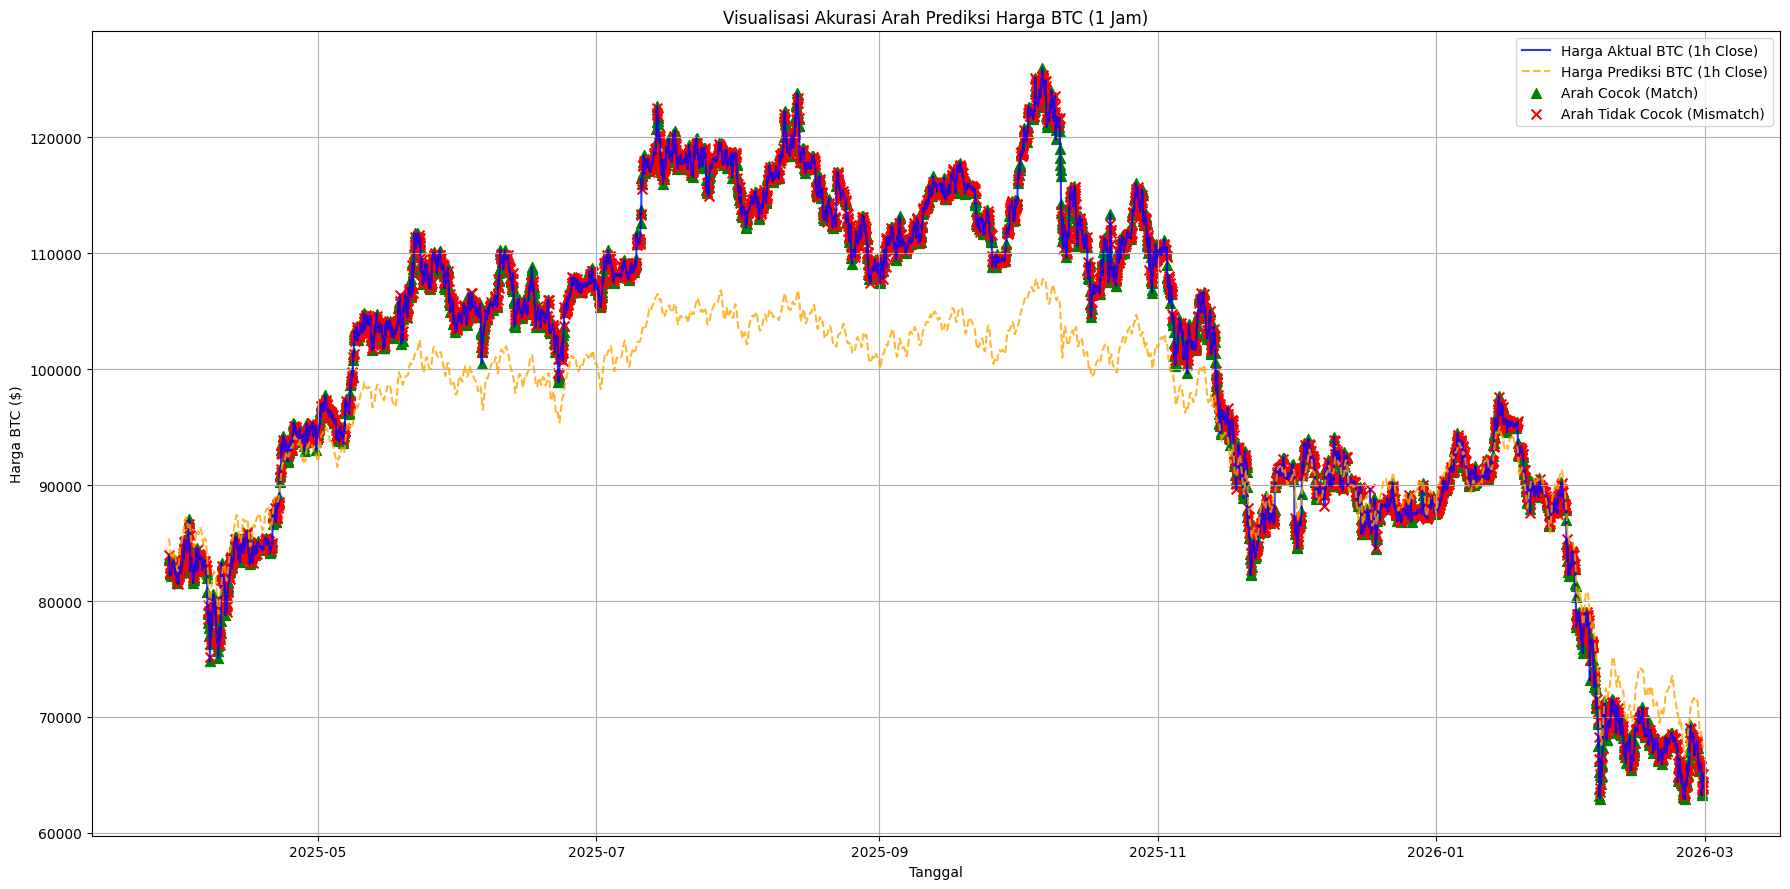

Visualisasi akurasi arah pergerakan harga selesai.


In [28]:
# ==========================================================
# @title Visualisasi Akurasi Arah Pergerakan Harga
# ==========================================================
print("Memvisualisasikan akurasi arah pergerakan harga...")

# Memastikan lstm_strategy_data tersedia dan memiliki kolom yang diperlukan
if 'lstm_strategy_data' not in globals() or lstm_strategy_data.empty:
    raise ValueError("DataFrame 'lstm_strategy_data' tidak ditemukan atau kosong. Pastikan sel 'Mendefinisikan aturan trading berbasis prediksi LSTM...' dan perhitungan akurasi arah telah dijalankan.")

if not all(col in lstm_strategy_data.columns for col in ['Harga_Aktual', 'Harga_Prediksi', 'Direction_Match', 'Actual_Direction']):
    raise ValueError("Kolom yang diperlukan ('Harga_Aktual', 'Harga_Prediksi', 'Direction_Match', 'Actual_Direction') tidak ditemukan di 'lstm_strategy_data'. Pastikan perhitungan akurasi arah telah berhasil.")

plt.figure(figsize=(18, 9))
plt.plot(lstm_strategy_data['Harga_Aktual'], label='Harga Aktual BTC (1h Close)', alpha=0.8, color='blue')
plt.plot(lstm_strategy_data['Harga_Prediksi'], label='Harga Prediksi BTC (1h Close)', alpha=0.8, linestyle='--', color='orange')

# Filter untuk kecocokan dan ketidakcocokan, mengabaikan baris NaN pertama dari pct_change
# Akan menggunakan common_index yang diperoleh di sel 9c35a27b.

# Filter berdasarkan kolom Direction_Match yang sudah ada di lstm_strategy_data
matches_data = lstm_strategy_data[lstm_strategy_data['Direction_Match'] == 1].dropna(subset=['Actual_Direction'])
mismatches_data = lstm_strategy_data[lstm_strategy_data['Direction_Match'] == 0].dropna(subset=['Actual_Direction'])

# Plot kecocokan arah
plt.scatter(
    matches_data.index,
    matches_data['Harga_Aktual'],
    marker='^',
    color='green',
    s=50,
    label='Arah Cocok (Match)'
)

# Plot ketidakcocokan arah
plt.scatter(
    mismatches_data.index,
    mismatches_data['Harga_Aktual'],
    marker='x',
    color='red',
    s=50,
    label='Arah Tidak Cocok (Mismatch)'
)

plt.title('Visualisasi Akurasi Arah Prediksi Harga BTC (1 Jam)')
plt.xlabel('Tanggal')
plt.ylabel('Harga BTC ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Visualisasi akurasi arah pergerakan harga selesai.")

In [31]:
 # ==========================================================
# @title Prediksi Harga BTC_1h_Close untuk Periode N-Langkah ke Depan
# ==========================================================

print("Membuat prediksi harga BTC_1h_Close untuk periode N-langkah ke depan...")

# Memuat model terbaik yang telah disimpan
from tensorflow.keras.models import load_model

model_dir = '/content/drive/MyDrive/Colab Notebooks/Prediction_Crypto_LSTM/04_1HBTC/'
filepath = os.path.join(model_dir, 'best_model.keras')
model = load_model(filepath) # Pastikan model sudah dimuat

# --- Input Jumlah Langkah Prediksi --- #
# Anda bisa mengubah nilai ini sesuai dengan berapa periode 1 jam ke depan yang ingin diprediksi
num_future_steps = 24 # Contoh: memprediksi 24 periode 1-jam ke depan (total 24 jam)
print(f"Akan memprediksi harga untuk {num_future_steps} periode 1-jam ke depan.")

# 1. Ambil urutan data terakhir dari X_test sebagai input awal
# Ini adalah 'window_len' data terakhir yang digunakan model untuk validasi.
current_input_sequence = X_test[-1].copy() # Buat salinan agar tidak mengubah X_test asli

# Simpan prediksi masa depan
future_predictions_scaled = []

# Dapatkan indeks kolom target 'BTC_1h_Close' dari feature_cols
feature_cols = data.select_dtypes(include=np.number).columns.tolist()
btc_close_idx = feature_cols.index('BTC_1h_Close') # Mengubah target ke BTC_1h_Close

# --- Loop untuk ramalan multi-langkah ---
for _ in range(num_future_steps):
    # Reshape untuk input model: (1 sampel, window_len, features)
    # model.predict() mengharapkan input dengan dimensi batch.
    input_for_prediction = current_input_sequence.reshape(1, window_len, current_input_sequence.shape[1])

    # Lakukan prediksi
    predicted_scaled_value = model.predict(input_for_prediction, verbose=0)[0][0]
    future_predictions_scaled.append(predicted_scaled_value)

    # --- Konstruksi urutan input berikutnya untuk prediksi langkah selanjutnya ---
    # Hapus timestep tertua dari urutan input
    new_input_sequence = np.delete(current_input_sequence, 0, axis=0)

    # Buat timestep baru dengan prediksi baru
    # Asumsi: Untuk fitur lain selain BTC_1h_Close, gunakan nilai dari timestep terakhir yang diketahui.
    # Ini adalah penyederhanaan yang penting.
    last_known_timestep_features = current_input_sequence[-1].copy()
    last_known_timestep_features[btc_close_idx] = predicted_scaled_value

    # Tambahkan timestep baru ke urutan input
    current_input_sequence = np.vstack([new_input_sequence, last_known_timestep_features])

# 3. Diskalakan kembali prediksi ke rentang harga asli
future_predictions_descaled = []
for scaled_val in future_predictions_scaled:
    dummy_array = np.zeros((1, len(feature_cols)))
    dummy_array[0, btc_close_idx] = scaled_val
    descaled_val = scaler_data_frame.inverse_transform(dummy_array)[0, btc_close_idx]
    future_predictions_descaled.append(descaled_val)

# Mendapatkan tanggal dan jam untuk prediksi t+1, t+2, ..., t+N
last_actual_date = lstm_strategy_data.index[-1] # Tanggal terakhir dari data yang sudah dievaluasi
# Karena kita memprediksi 1-jam, tambahkan 1 jam untuk setiap langkah
future_dates = [last_actual_date + pd.Timedelta(hours=(i+1)*1) for i in range(num_future_steps)]

print(f"\nHarga Aktual BTC_1h_Close terakhir ({last_actual_date}): {y_test_denormalisasi[-1]:.2f}") # Gunakan y_test_denormalisasi karena itu 1h
print("\nPrediksi Harga BTC_1h_Close untuk periode N-langkah ke depan:")
for date, pred_price in zip(future_dates, future_predictions_descaled):
    print(f"  {date}: {pred_price:.2f}")

print("\nRamalan N-langkah ke depan selesai.")

Membuat prediksi harga BTC_1h_Close untuk periode N-langkah ke depan...
Akan memprediksi harga untuk 24 periode 1-jam ke depan.

Harga Aktual BTC_1h_Close terakhir (2026-02-28 15:00:00): 64807.90

Prediksi Harga BTC_1h_Close untuk periode N-langkah ke depan:
  2026-02-28 16:00:00: 67469.23
  2026-02-28 17:00:00: 67594.72
  2026-02-28 18:00:00: 67743.80
  2026-02-28 19:00:00: 67898.80
  2026-02-28 20:00:00: 68048.69
  2026-02-28 21:00:00: 68186.54
  2026-02-28 22:00:00: 68306.91
  2026-02-28 23:00:00: 68412.69
  2026-03-01 00:00:00: 68503.98
  2026-03-01 01:00:00: 68583.00
  2026-03-01 02:00:00: 68652.21
  2026-03-01 03:00:00: 68711.22
  2026-03-01 04:00:00: 68761.66
  2026-03-01 05:00:00: 68804.91
  2026-03-01 06:00:00: 68845.96
  2026-03-01 07:00:00: 68880.33
  2026-03-01 08:00:00: 68907.22
  2026-03-01 09:00:00: 68929.31
  2026-03-01 10:00:00: 68947.15
  2026-03-01 11:00:00: 68961.66
  2026-03-01 12:00:00: 68973.77
  2026-03-01 13:00:00: 68983.75
  2026-03-01 14:00:00: 68989.19
  202